In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as cx
import momepy
import networkx as nx
import shapely
from cityseer.tools import io, graphs, plot
from cityseer.metrics import networks, layers
from matplotlib_scalebar.scalebar import ScaleBar

c:\Users\Alexander\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nodes = gpd.read_file('./wegengraaf2/points.shp').to_crs(epsg=3857)
lines = gpd.read_file('./wegengraaf2/lines.shp').to_crs(epsg=3857)
cities = gpd.read_file('./wegengraaf2/cities.shp').to_crs(epsg=3857)

## Modificaties shapefile data

In [4]:
lines_28992 = lines.to_crs(epsg=28992) # on average 1m accuracy, testing roughly gives the same result (1.92 km approx 2.00 km)
lines['length'] = lines_28992.length

In [5]:
lines['nbanen'] = 1 # rest, Nweg is 'Nxxx'
cond = lines['wegnr'].apply(lambda x: x is not None and x[0] == '0')
lines.loc[cond, 'nbanen'] = 2

In [6]:
# if x, y is nan, use geometry data
nodes.loc[np.isnan(nodes['x']), 'x'] = nodes[np.isnan(nodes['x'])].geometry.x
nodes.loc[np.isnan(nodes['y']), 'y'] = nodes[np.isnan(nodes['y'])].geometry.x

In [7]:
# negeer dit als QGIS open is
nodes.to_file('./wegengraaf2/points.shp')
lines.to_file('./wegengraaf2/lines.shp')

INFO:pyogrio._io:Created 271 records
INFO:pyogrio._io:Created 321 records


## Structuur shapefiles

In [8]:
nodes[nodes['is_auto_br'] == 1] # geeft alle steden weer

,x,y,nodeID,stad_naam,is_auto_br,spawn_hoev,geometry
255,645309.193407,645309.193407,1000.0,Leeuwarden,1.0,0.0,POINT (645309.193 7020035.517)
256,678687.356347,678687.356347,1001.0,Drachten,1.0,0.0,POINT (678687.356 7003402.433)
257,630507.335802,630507.335802,1002.0,Sneek,1.0,0.0,POINT (630507.336 6989434.974)
262,659133.629811,659133.629811,1003.0,Heerenveen,1.0,0.0,POINT (659133.63 6975404.715)
263,603962.072195,603962.072195,1004.0,Harlingen,1.0,0.0,POINT (603962.072 7015736.489)
264,645899.001627,645899.001627,1005.0,Joure,1.0,0.0,POINT (645899.002 6976587.413)
265,668019.682772,668019.682772,1006.0,Wolvega,1.0,0.0,POINT (668019.683 6960374.304)
266,617080.349435,617080.349435,1007.0,Franeker,1.0,0.0,POINT (617080.349 7017852.729)
267,667774.750484,667774.750484,1008.0,Dokkum,1.0,0.0,POINT (667774.75 7043345.249)
268,635511.580819,635511.580819,1009.0,Lemmer,1.0,0.0,POINT (635511.581 6954311.894)


In [9]:
lines

,wegnr,length,maxshd,node_start,node_end,nbanen,geometry
0,N393,1924.333925,80,0,1,1,"LINESTRING (634450.288 7034871.712, 634130.3 7..."
1,N393,1660.777370,50,0,86,1,"LINESTRING (636926.484 7034136.391, 635716.5 7..."
2,N380,2271.218173,60,2,3,1,"LINESTRING (678454.257 6976977.584, 678365.673..."
3,None,2289.789993,80,2,5,1,"LINESTRING (678454.257 6976977.584, 678409.5 6..."
4,N380,1177.078109,60,2,216,1,"LINESTRING (678454.257 6976977.584, 678483.198..."
...,...,...,...,...,...,...,...
316,Bolsward West,1580.854233,50,1010,57,1,"LINESTRING (613403.016 6994234.021, 613602.41 ..."
317,Burgum Zuid,1555.615683,50,1011,205,1,"LINESTRING (666518.887 7018843.045, 666711.848..."
318,Burgum-Noord,1557.198917,50,1011,156,1,"LINESTRING (666493.158 7018830.181, 666403.11 ..."
319,Friesland Zuid 2,4683.209945,50,1000,175,1,"LINESTRING (645406.714 7012605.739, 644955.789..."


In [15]:
import matplotlib.patheffects as pe

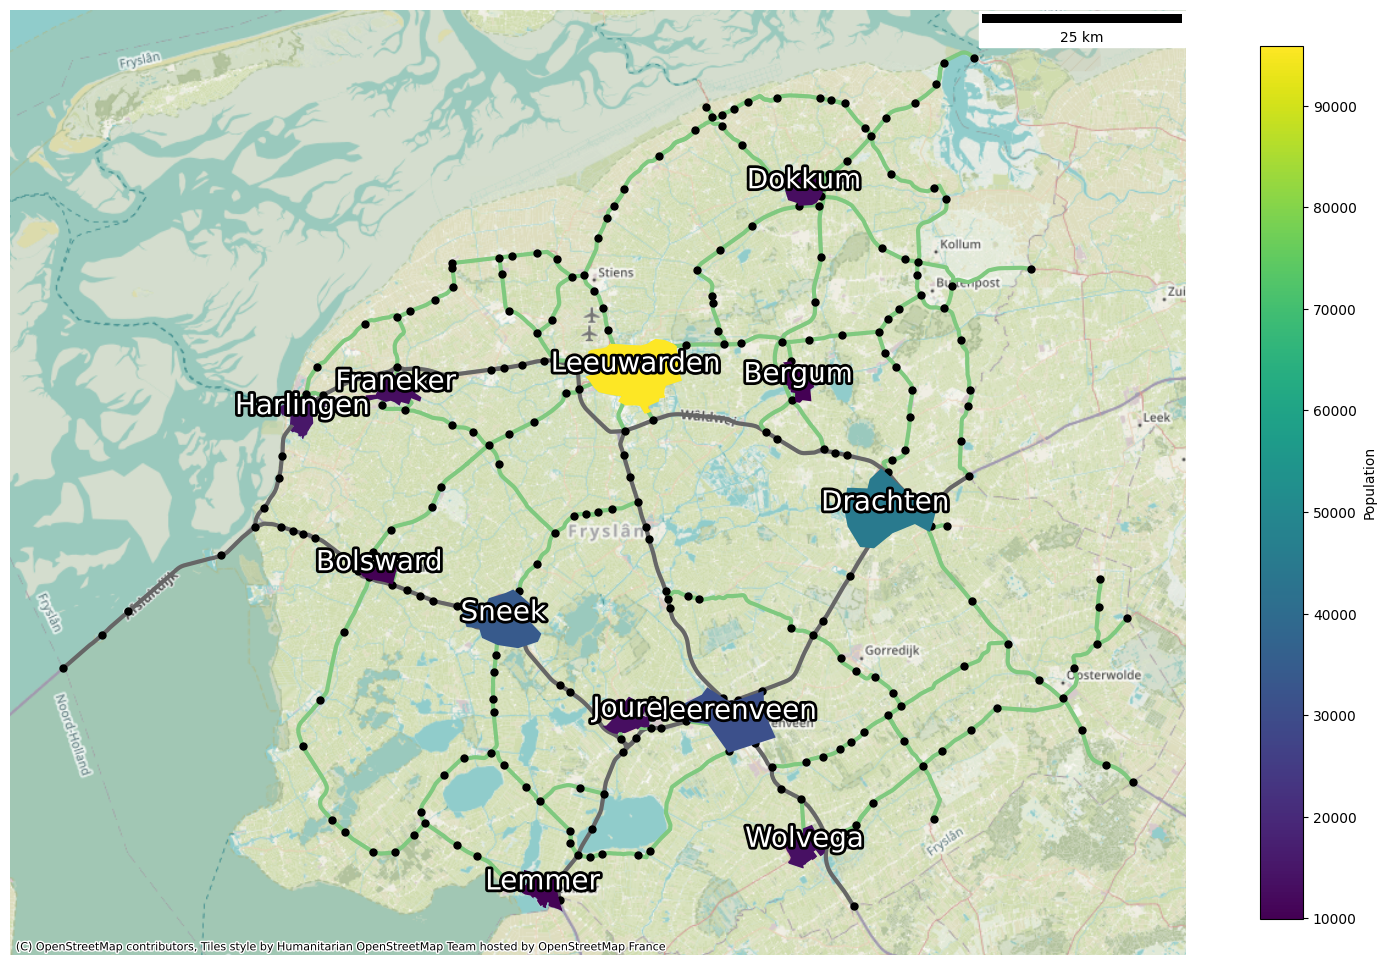

In [32]:
ax = lines.plot(column='nbanen',
                cmap='Accent',
                figsize=(15,10),
                linewidth=3,
                # legend=True,
                # legend_kwds={'label': 'Aantal banen', 'shrink': 0.6},
                zorder=1)

ax.add_artist(ScaleBar(1)) # scale bar (25 km)

nodes.plot(ax=ax, markersize=25, color='black', zorder=2)


cities.plot(ax=ax, 
            column='population',
            cmap='viridis',
            legend=True,
            legend_kwds={'label': 'Population', 'shrink': 0.9},
            zorder=3)

cx.add_basemap(ax)

# namen van steden
cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=20, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)

# cx.add_basemap(ax)

ax.set_axis_off()

plt.tight_layout()

plt.savefig('./friesland_finalnetwork.png', dpi=300)
